In [3]:
import sys
sys.path.append('../')

In [4]:
import os
import csv

from protein_atlas.data import load_data
from protein_atlas.image import preprocess

import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve
from keras.models import load_model
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from ipywidgets import interact

%matplotlib inline

Using TensorFlow backend.


In [5]:
EXPERIMENT_DIR =  '../experiments/simple_convnet_v1/2018-10-07-08-48-33/'
CHECKPOINT_PATH = '../experiments/simple_convnet_v1/2018-10-07-08-48-33/weights.23-3.177363.hdf5'
SUBMISSION_PATH = '../experiments/simple_convnet_v1/2018-10-07-08-48-33/submission.csv'
DATA_PATH = '../data/train.csv'
TEST_PATH = '../data/sample_submission.csv'
IMAGE_DIR = '../data/train'
TEST_IMAGE_DIR = '../data/test/'

In [6]:
X, y = load_data(DATA_PATH, IMAGE_DIR)
_, X_val, _, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
del X, y

100%|██████████| 31072/31072 [00:24<00:00, 1274.87it/s]


In [7]:
preprocess(X_val)

In [8]:
n_classes = y_val.shape[-1]

## Prediction

In [9]:
model = load_model(CHECKPOINT_PATH)

In [10]:
y_pred = model.predict(X_val, verbose=1)

6215/6215 [==============================] - 44s 7ms/step


## Calibration

In [11]:
calibrators = [IsotonicRegression(out_of_bounds='clip').fit(y_pred[:, i], y_val.argmax(-1) == i) 
               for i in tqdm(range(y_val.shape[-1]))]

In [12]:
y_pred_calibrated = y_pred.copy()
for i, calibrator in enumerate(calibrators):
    y_pred_calibrated[:, i] = calibrator.transform(y_pred_calibrated[:, i])

In [13]:
def plot_calibration_curve(i):
    true_raw, pred_raw = calibration_curve(y_val.argmax(-1) == i, y_pred[:, i])
    plt.plot(pred_raw, true_raw, label='uncalibrated')
    true_calibrated, pred_calibrated = calibration_curve(y_val.argmax(-1) == i, y_pred_calibrated[:, i])
    plt.plot(pred_calibrated, true_calibrated, label='calibrated')
    plt.xlabel('Predicted')
    plt.ylabel('True %')
    plt.legend(loc='lower right')
    plt.show()

_ = interact(plot_calibration_curve, i=list(range(n_classes)))

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [20]:
joblib.dump(calibrators, os.path.join(EXPERIMENT_DIR, 'calibrators.pkl'), compress=3)

['../experiments/simple_convnet_v1/2018-10-07-08-48-33/calibrators.pkl']

## Thresholding

In [14]:
def f1(precision, recall):
    return 2 * ((precision * recall) / (precision + recall))

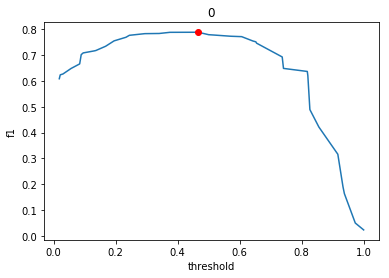

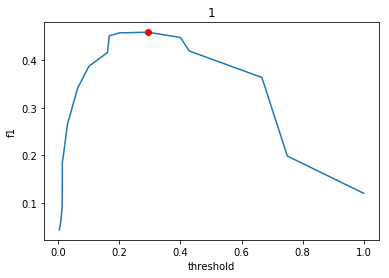

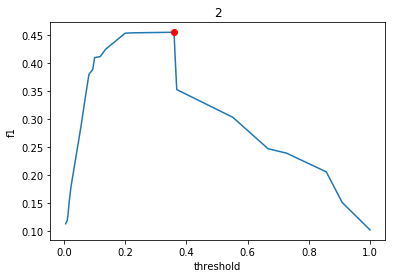

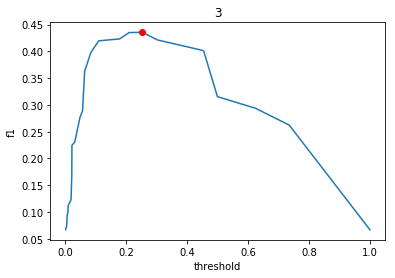

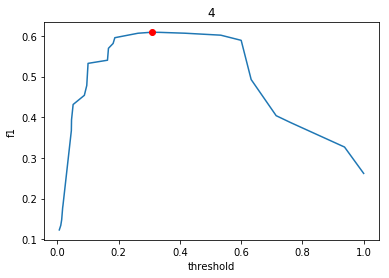

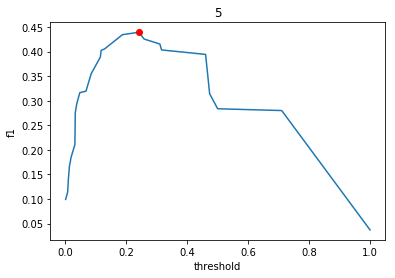

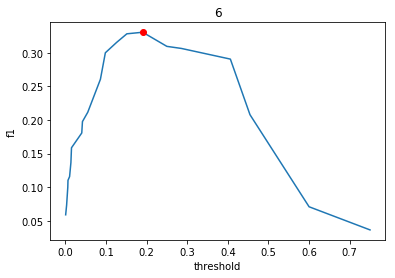

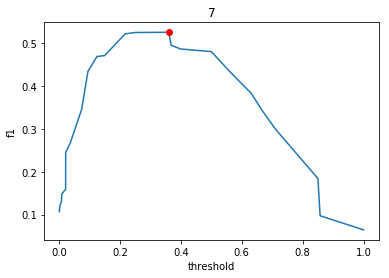

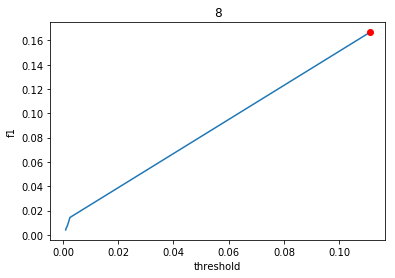

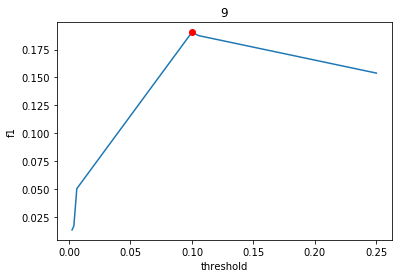

/home/ben/virtualenvs/protein-atlas/lib/python3.6/site-packages/sklearn/metrics/ranking.py:521: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


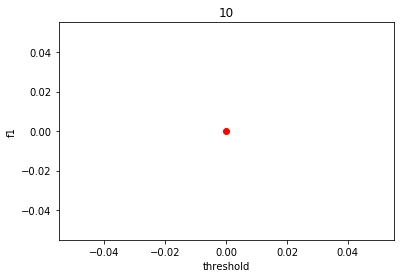

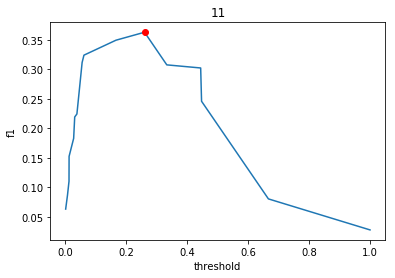

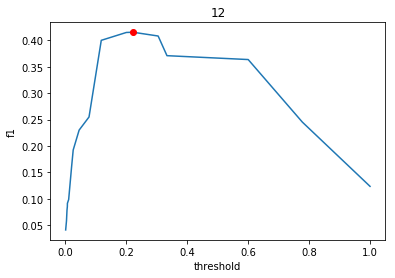

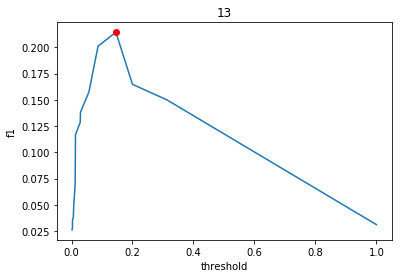

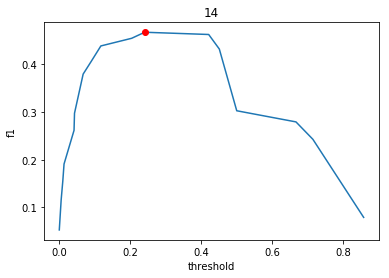

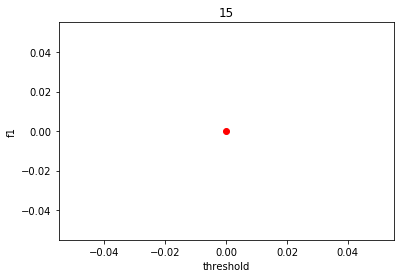

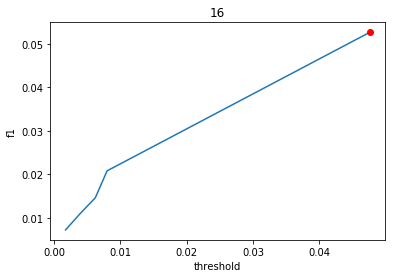

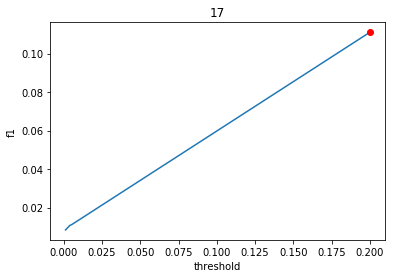

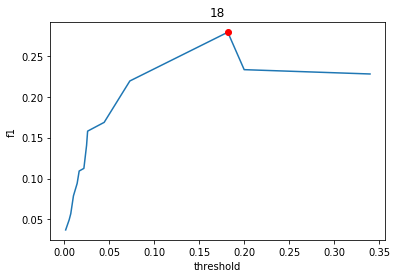

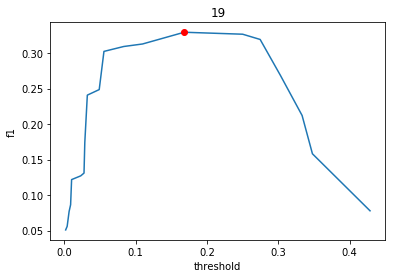

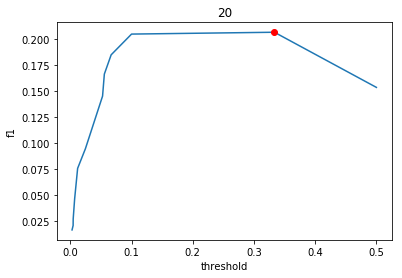

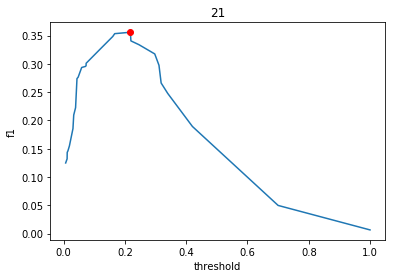

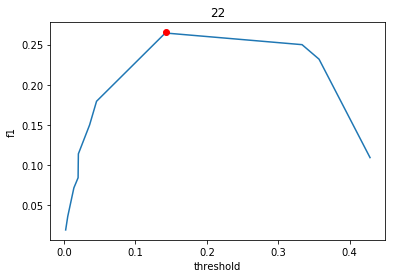

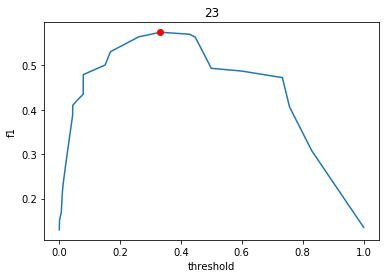

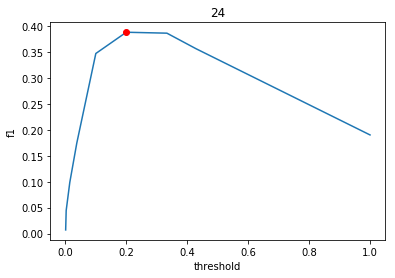

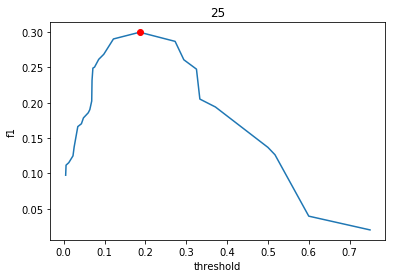

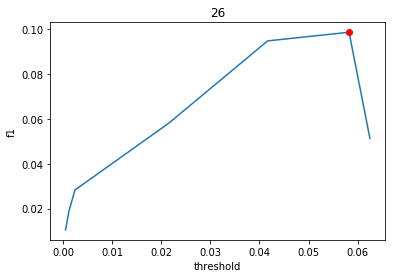

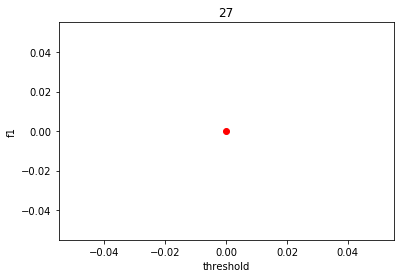

In [15]:
selected_thresholds = np.zeros(n_classes)
scores = np.zeros(n_classes)
for i in range(n_classes):
    precisions, recalls, thresholds = precision_recall_curve(y_val.argmax(-1) == i, y_pred_calibrated[:, i])
    f1_scores = np.array([f1(p, r) for p, r in zip(precisions[:-1], recalls[:-1])])
    f1_scores[np.isnan(f1_scores)] = 0
    scores[i] = f1_scores.max()
    selected_thresholds[i] = thresholds[f1_scores.argmax()]
    plt.title('{}'.format(i))
    plt.plot(thresholds, f1_scores)
    plt.plot(selected_thresholds[i], scores[i], 'ro')
    plt.xlabel('threshold')
    plt.ylabel('f1')
    plt.show()

In [16]:
print('val macro f1:', scores.mean())

val macro f1: 0.3150247875974107


In [17]:
selected_thresholds[scores == 0] = 1

In [19]:
np.savetxt(os.path.join(EXPERIMENT_DIR, 'thresholds.csv'), selected_thresholds, delimiter=',')

## Submission

In [18]:
X_test, y_test = load_data(TEST_PATH, TEST_IMAGE_DIR)

100%|██████████| 11702/11702 [00:12<00:00, 950.92it/s]


In [21]:
preprocess(X_test)

In [22]:
y_pred_test = model.predict(X_test, verbose=1)

11702/11702 [==============================] - 86s 7ms/step


In [23]:
for i, calibrator in enumerate(calibrators):
    y_pred_test[:, i] = calibrator.transform(y_pred_test[:, i])

In [24]:
predicted_classes = y_pred_test > selected_thresholds

In [25]:
with open(TEST_PATH) as test_file:
    reader = csv.reader(test_file)
    next(reader)
    ids = [uid for uid, _ in reader]
    
with open(SUBMISSION_PATH, 'w') as submission_file:
    writer = csv.writer(submission_file)
    writer.writerow(['Id', 'Predicted'])
    for i, (uid, preds) in tqdm(enumerate(zip(ids, predicted_classes))):
        classes = ' '.join(str(i) for i in np.where(preds == 1)[0])
        writer.writerow([uid, classes])